# 0.数据集介绍与实验准备

## 数据集介绍
该数据是威斯康星州乳腺癌诊断数据库，里面共有699个样本，每个样本有10个特征（其中1个是统计编号），1个标签。样本特征含义及取值范围如下：
1.编号
2.块厚度
3.细胞大小的一致性
4.细胞形状的均匀性
5.边缘附着力
6.单个上皮细胞大小
7.裸核
8.染色质
9.正常核仁
10.有丝分裂
11.分类：（2为良性，4为恶性）
特征2-10的取值范围均为[1,10]

## 实验准备

### 进入ModelArts界面

点击如下链接：https://www.huaweicloud.com/product/modelarts.html ，进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面。

### 创建ModelArts Notebook

下面，我们在ModelArts中创建一个notebook开发环境，ModelArts notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”

![create_nb_create_button](./img/create_nb_create_button.png)

第二步：填写notebook所需的参数：

| 参数 | 说明 |
| - - - - - | - - - - - |
| 计费方式 | 按需计费  |
| 名称 | Notebook实例名称，如 kmeans_customer_segmentation |
| 工作环境 | Python3 |
| 资源池 | 选择"公共资源池"即可 |
| 类型 | CPU |
| 规格 | 2核8GiB |
| 存储配置 | 选择EVS，磁盘规格5GB |

第三步：配置好notebook参数后，点击下一步，进入notebook信息预览。确认无误后，点击“立即创建”

![create_nb_creation_summary](./img/create_nb_creation_summary.png)

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作。
![modelarts_notebook_index](./img/modelarts_notebook_index.png)

### 在ModelArts中创建开发环境

接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook
![inter_dev_env](img/enter_dev_env.png)

第二步：创建一个Python3环境的的Notebook。点击右上角的"New"，然后创建 XGBoost-Sklearn 开发环境。

第三步：点击左上方的文件名"Untitled"，并输入一个与本实验相关的名称，如"knn-breast-cancer-classfication"
![notebook_untitled_filename](./img/notebook_untitled_filename.png)
![notebook_name_the_ipynb](./img/notebook_name_the_ipynb.png)


### 在Notebook中编写并执行代码

在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：
![run_helloworld](./img/run_helloworld.png)


开发环境准备好啦，接下来可以愉快地写代码啦！


## 导入类库

In [256]:
import pandas as pd
from pandas import read_csv
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import requests 
from sklearn import datasets
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

# 1.数据预处理

## 1.1下载数据并显示前5行
本样例数据已经预先被上传到公共OBS桶里，我们只需要下载读取即可

In [255]:
url = 'https://modelarts-labs.obs.cn-north-1.myhuaweicloud.com/notebook/ML_breast_cancer_wisconsin/breast-cancer-wisconsin.data'
r = requests.get(url) 
with open("./breast-cancer-wisconsin.data", "wb") as code:
    code.write(r.content)
breast_cancer_data =pd.read_csv('./breast-cancer-wisconsin.data',header=None
                               ,names = ['numbers','Clump_Thickness','Uniformity_of_Cell_Size','Uniformity_of_Cell_Shape','Marginal_Adhesion',
                                         'Single_Epithelial_Cell_Size'
                                        ,'Bare_Nuclei','Bland_Chromatin','Normal_Nucleoli','Mitoses','Class'])
breast_cancer_data.head(5)

,numbers,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [251]:
data=breast_cancer_data
data.head()
data=data.drop(['numbers'], axis=1)  # 将序号列去掉
len(data)

699

## 1.2数值属性概括

describe()方法可以展示数值属性的概括。
其中,count是非空值的总数量，mean是平均数，std是标准差，25%，50%，75%表示对呀的分位数。

In [124]:
data.describe()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


## 1.3数据的描述（总行数、每个属性的类型、非空值数量）
info()方法可以快速查看数据的描述，特别是总行数、每个属性的类型和非空值的数量。

In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
Clump_Thickness                699 non-null int64
Uniformity_of_Cell_Size        699 non-null int64
Uniformity_of_Cell_Shape       699 non-null int64
Marginal_Adhesion              699 non-null int64
Single_Epithelial_Cell_Size    699 non-null int64
Bare_Nuclei                    699 non-null object
Bland_Chromatin                699 non-null int64
Normal_Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: int64(9), object(1)
memory usage: 54.7+ KB


## 1.3异常值处理

我们可以从上面看到，数据里“Bare_Nuclei”这一列是object特征，我们可以打印一下这一列观察一下数据：

In [126]:
for index,row in data.iterrows():
    print(row['Bare_Nuclei'])

1
10
2
4
1
10
10
1
1
1
1
1
3
3
9
1
1
1
10
1
10
7
1
?
1
7
1
1
1
1
1
1
5
1
1
1
1
1
10
7
?
3
10
1
1
1
9
1
1
8
3
4
5
8
8
5
6
1
10
2
3
2
8
2
1
2
1
10
9
1
1
2
1
10
4
2
1
1
3
1
1
1
1
2
9
4
8
10
1
1
1
1
1
1
1
1
1
1
6
10
5
5
1
3
1
3
10
10
1
9
2
9
10
8
3
5
2
10
3
2
1
2
10
10
7
1
10
1
10
1
1
1
10
1
1
2
1
1
1
?
1
1
5
5
1
?
8
2
1
10
1
10
5
3
1
10
1
1
?
10
10
1
1
3
?
2
10
1
1
1
1
1
1
10
10
10
1
1
1
10
1
1
1
10
10
1
8
10
8
1
8
10
1
1
1
1
7
1
1
1
10
10
1
1
1
10
5
1
1
1
10
8
1
10
10
5
1
1
4
1
1
10
5
8
10
1
10
5
1
10
7
8
1
10
1
?
10
2
9
10
2
1
1
5
1
2
10
9
1
?
1
10
10
10
8
10
1
1
1
8
10
10
10
10
3
1
10
10
4
1
10
1
10
4
1
?
1
1
1
7
1
1
10
10
10
10
10
1
5
10
1
1
?
10
?
10
5
?
1
10
4
1
10
1
10
10
1
1
3
5
1
1
1
1
1
?
10
8
1
5
10
?
1
10
1
1
10
1
4
10
8
1
1
10
10
1
10
1
1
10
10
1
1
1
10
1
1
1
1
8
1
1
3
10
1
1
3
10
4
7
10
10
3
3
1
1
10
10
1
1
1
1
1
1
1
1
1
1
1
1
1
10
1
1
1
1
10
1
1
2
1
10
1
1
1
1
1
1
1
1
9
1
1
4
1
1
1
1
2
1
1
?
4
1
10
3
10
1
2
1
3
10
1
1
1
10
1
2
1
1
1
1
1
1
8
10
1
1
1
1
10
4
3
2
1
1
1
1
1
10


我们可以观察到，除了数字外，还有一些字符型的，比如问号，可能是收集数据的时候统计不全，我们现在找到这部分特征，打印出这部分字符和其位置，并用均值替代它们。

In [127]:
Bare_Nuclei=[]
count_null=0
for index,row in data.iterrows():
    try:
        Bare_Nuclei.append(int(row['Bare_Nuclei']))
    except:
        count_null+=1
        Bare_Nuclei.append(0)
        print(row['Bare_Nuclei'],index)
Bare_Nuclei_np=np.array(Bare_Nuclei)
Bare_Nuclei_mean=np.sum(Bare_Nuclei)//(len(Bare_Nuclei)-count_null)
for i in range(len(Bare_Nuclei)):
    if Bare_Nuclei[i]==0:
        Bare_Nuclei[i]=Bare_Nuclei_mean
    Bare_Nuclei[i]=int(Bare_Nuclei[i])
data['Bare_Nuclei']=Bare_Nuclei

? 23
? 40
? 139
? 145
? 158
? 164
? 235
? 249
? 275
? 292
? 294
? 297
? 315
? 321
? 411
? 617


再次查看数据描述，如下，可以看到，每一列都变成数值特征了

In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
Clump_Thickness                699 non-null int64
Uniformity_of_Cell_Size        699 non-null int64
Uniformity_of_Cell_Shape       699 non-null int64
Marginal_Adhesion              699 non-null int64
Single_Epithelial_Cell_Size    699 non-null int64
Bare_Nuclei                    699 non-null int64
Bland_Chromatin                699 non-null int64
Normal_Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: int64(10)
memory usage: 54.7 KB


# 2.数据相关性分析

## 2.1数据类别统计
类别为2（即未患癌症）的热不是故意和类别为4（即患癌症）的人数统计和示意图如下：

Class
2    458
4    241
dtype: int64


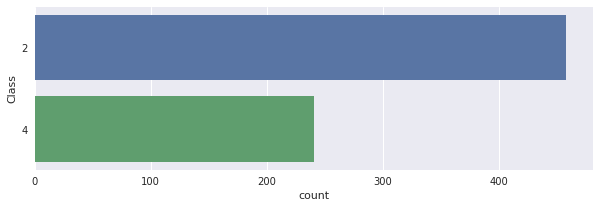

In [129]:
print(breast_cancer_data.groupby('Class').size())
plt.figure(1 , figsize = (10 , 3))
sns.countplot(y = 'Class' , data = data)
plt.show()

## 2.2各类别特征情况统计
下图表示患癌者和未患癌者每一类特征的平均值，可以看到，患癌者的每一类特征都普遍比较高，未患癌者都普遍比较低，相关性较强

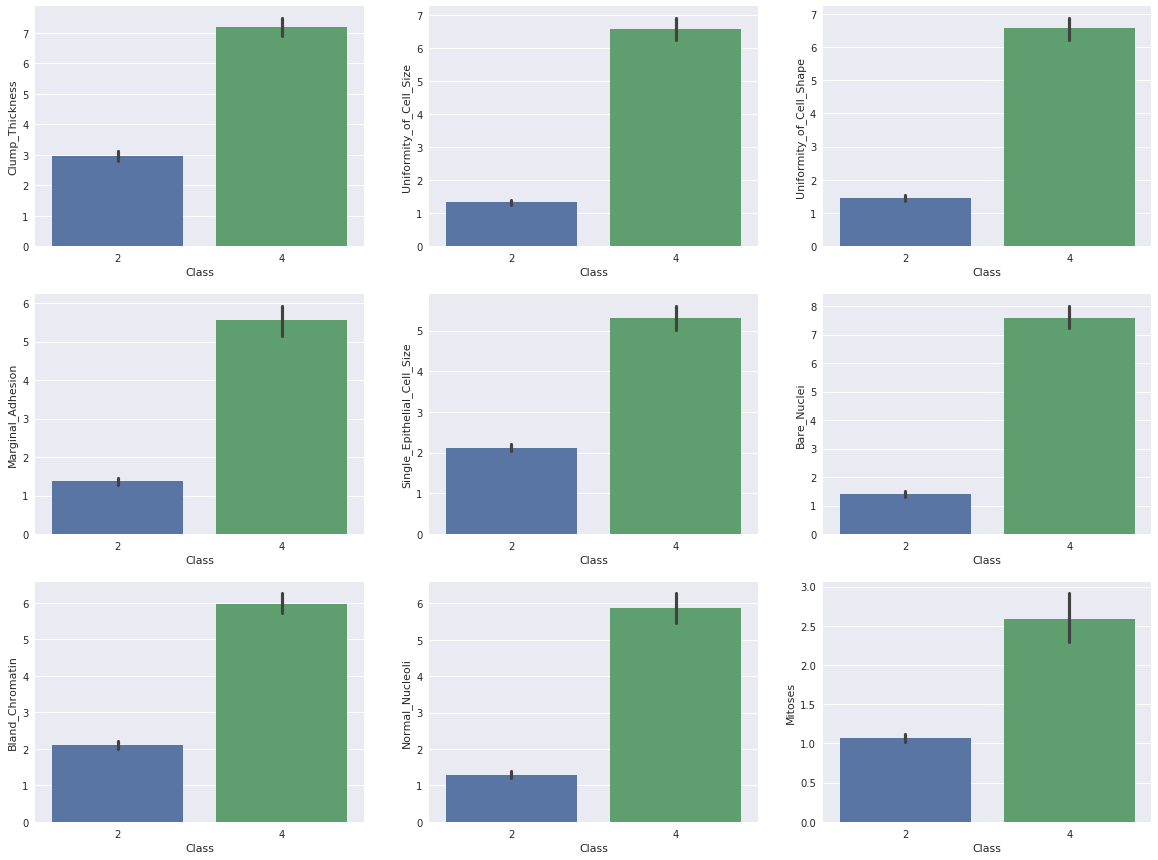

In [130]:
fig,axes = plt.subplots(3,3,figsize=(20,15))
draw_column=['Clump_Thickness','Uniformity_of_Cell_Size','Uniformity_of_Cell_Shape','Marginal_Adhesion',
                                         'Single_Epithelial_Cell_Size'
                                        ,'Bare_Nuclei','Bland_Chromatin','Normal_Nucleoli','Mitoses']
ax_list=[axes[0,0],axes[0,1],axes[0,2],axes[1,0],axes[1,1],axes[1,2],axes[2,0],axes[2,1],axes[2,2]]
for i,column in enumerate(draw_column):
    sns.barplot(y=column,x='Class',data=data,ax=ax_list[i])
plt.show()
plt.close()
#     sns.barplot(x='Uniformity of Cell Size',y='Class',data=data,ax=axes[)
#     sns.barplot(x='Marginal Adhesion',y='Class',data=data,ax=axes[0,2])
# sns.barplot(x='Marginal Adhesion',y='Uniformity of Cell Size',hue='Class',data=data,ax=axes[1,1])
# sns.barplot(y='Bare Nuclei',x='Class',data=data,ax=axes[2,1])

##  2.3系数矩阵绘制 
相关系数矩阵，常用的有皮尔逊相关系数(Pearson product-moment correlation coefficient，Pearson's r)的方阵，通过它可以来衡量两个特征之间的线性关系。皮尔逊相关系数的取值在[-1,1]范围内，如果r=1，表示两个变量呈正相关，r=0表示两个变量没有关系，r=-1表示两个变量呈负相关。其实，相关系数矩阵就是标准化的协方差矩阵。
下图也可以看到，各个特征与标签的相关性都较强，所以我们在此用例不用作特征剔除操作。

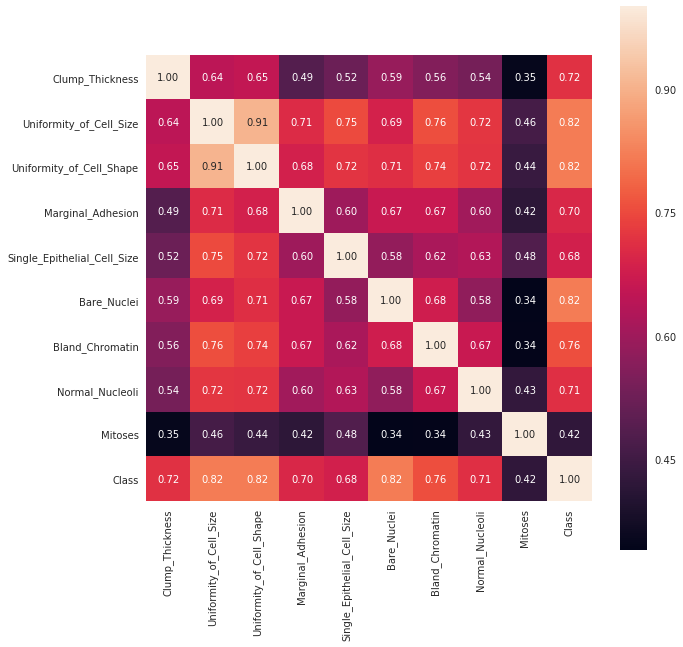

In [131]:
cols=['Clump_Thickness','Uniformity_of_Cell_Size','Uniformity_of_Cell_Shape','Marginal_Adhesion',
                                         'Single_Epithelial_Cell_Size'
                                        ,'Bare_Nuclei','Bland_Chromatin','Normal_Nucleoli','Mitoses','Class']

cm = np.corrcoef(data[cols].values.T)
#设置字的比例
plt.figure(figsize=(10,10))
sns.set(font_scale=1.0)
#绘制相关系数图
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt=".2f",
                 annot_kws={"size":10},yticklabels=cols,xticklabels=cols)
plt.show()

# 2.KNN算法使用示例
邻近算法，或者说K最近邻(kNN，k-NearestNeighbor)分类算法是数据挖掘分类技术中最简单的方法之一。所谓K最近邻，就是k个最近的邻居的意思，说的是每个样本都可以用它最接近的k个邻居来代表。

## 2.1 训练集测试集划分
将训练集测试集作8比2划分

In [238]:
data_np=np.array(data)


train_data, test_data= train_test_split(data_np,  test_size=0.2,random_state=2019) 

train_data_np=np.array(train_data)
test_data_np=np.array(test_data)
train_label_np=train_data_np[:,-1]   #训练集的标签
test_label_np=train_data_np[:,-1]

train_data_df= pd.DataFrame(train_data,columns=cols)
train_data_df.to_csv('./train_data.csv',index=None)

test_data_df= pd.DataFrame(test_data,columns=cols)
test_data_df.to_csv('./test_data.csv',index=None)
train_data_path='./train_data.csv'
test_data_path='./test_data.csv'

## 2.2 训练和测试
如下read_csv函数可以直接把csv文件转换成算法所需要的格式

calculate_metric_value 函数可以测试模型性能，返回对应数据集在该模型下预测的f1值、准确率、召回率、查准率

训练、测试示意代码如下

In [239]:
from modelarts_pyspark.common import MeasurementType, Role, DataType, DfUtils, Meta, Attributes
from pyspark.sql.functions import expr
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer
def read_csv(path):

    df = DfUtils.read_csv(sc, path, has_header=True)
    new_list = DfUtils.modify_metadata(df.schema.fields, target='Class', name=Attributes.ROLE,
                                       value=Role.TARGET)
    fields = DfUtils.modify_metadata(new_list, target='Class', name=Attributes.MEASUREMENT,
                                     value=MeasurementType.NOMINAL)
    a=spark.createDataFrame(df.rdd, StructType(fields))
    return spark.createDataFrame(df.rdd, StructType(fields))


def calculate_metric_value(knn_model, knn_df):
    label_col=knn_df.select("Class")
    indexer = StringIndexer()
    indexer.setInputCol('Class')
    indexer.setOutputCol('label')
    index_model = indexer.fit(label_col)
    label_col = index_model.transform(label_col)
    label_col=label_col.toPandas()
    result = knn_model.transform(knn_df)

    indexer = StringIndexer()
    indexer.setInputCol('predict')
    indexer.setOutputCol('predictIndexer')
    index_model = indexer.fit(result)
    index_result = index_model.transform(result)
    index_result=index_result.toPandas()
    dataset = pd.concat([index_result,label_col],axis=1)
    dataset=spark.createDataFrame(dataset)
    evaluator = MulticlassClassificationEvaluator(predictionCol="predictIndexer")

    metric_dict["f1"] = (evaluator.evaluate(dataset, {evaluator.metricName: "f1"}))
    metric_dict["accuracy"] = (evaluator.evaluate(dataset, {evaluator.metricName: "accuracy"}))
    metric_dict["precision"] = (evaluator.evaluate(dataset, {evaluator.metricName: "weightedPrecision"}))
    metric_dict["recall"] = (evaluator.evaluate(dataset, {evaluator.metricName: "weightedRecall"}))
    return index_result

In [240]:
from pyspark.sql.types import StructType
from modelarts_pyspark import KNNClassification,KNNRegression

train_data_frame = read_csv(train_data_path)
knn_classification = KNNClassification().set_k(3)
model = knn_classification.fit(train_data_frame)  #训练

test_data_frame = read_csv(test_data_path)
metric_dict = {}
calculate_metric_value(model, test_data_frame)   #测试
print(metric_dict)

{'f1': 0.9643627571057185, 'accuracy': 0.9642857142857143, 'precision': 0.9645453687092815, 'recall': 0.9642857142857143}


# 3.K折交叉验证

K折交叉验证(k-fold cross-validation)首先将所有数据分割成K份子样本，不重复的选取其中份个子样本作为测试集，其他K-1份样本用来训练。共重复K次，平均K次的结果或者使用其它指标，最终得到一个单一估测。

这个方法的优势在于，保证每个子样本都参与训练且都被测试，降低泛化误差。K折交叉验证常被用于模型调优，找到使得模型泛化性能最优的超参值。找到后，在全部训练集上重新训练模型，并使用独立测试集对模型性能做出最终评价。其中，10折、5折交叉验证等比较常用。

本例以5折交叉验证为例完成一个K折交叉验证得过程。将上面2.1中划分的训练集作为K折交叉验证的数据集，并在此上划分训练集、验证集。

In [241]:
from sklearn.model_selection import KFold
metric_dict = {}
model_list=[]
def train_kfold(data,knn_k,k_fold_num,is_print_metric_dict=True):  #输入依次数据，knn里的k值，K折交叉验证折数，是否打印每折模型评估信息，然后进行训练
    train_preds = np.zeros((len(data), 1))
    result=[]
    val_label_preds_list=[]
    val_label_true_list=[]
    fold = KFold(n_splits=k_fold_num, random_state=42)
    for im, (trn_idx, val_idx) in enumerate(fold.split(data)):
        train_data, val_data = data[trn_idx, :], data[val_idx, :]
        train_data_df= pd.DataFrame(train_data,columns=cols)
        train_data_df.to_csv('./train_data_k.csv',index=None)
        val_data_df= pd.DataFrame(val_data,columns=cols)
        val_data_df.to_csv('./val_data_k.csv',index=None)
        train_data_path_k='./train_data_k.csv'
        val_data_path_k='./val_data_k.csv'
        train_data_frame = read_csv(train_data_path_k)
        knn_classification = KNNClassification().set_k(knn_k)
        model = knn_classification.fit(train_data_frame)
        val_data_frame = read_csv(val_data_path_k)
        val_label_preds=np.zeros((len(val_idx),1))
        val_label_preds=np.array(calculate_metric_value(model, val_data_frame))[:,-1].reshape(len(val_idx), 1)
        train_preds[val_idx]=val_label_preds
        model_list.append(model)
        if is_print_metric_dict:
            print('knn_k:{},  fold_nums:{},  metric_dict:{}'.format(knn_k,im+1,metric_dict))
    return train_preds

In [242]:
train_preds=train_kfold(train_data,5,5)

knn_k:5,  fold_nums:1,  metric_dict:{'f1': 1.0, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0}
knn_k:5,  fold_nums:2,  metric_dict:{'f1': 0.9289115646258501, 'accuracy': 0.9285714285714286, 'precision': 0.9298714430160336, 'recall': 0.9285714285714286}
knn_k:5,  fold_nums:3,  metric_dict:{'f1': 0.9552191006272638, 'accuracy': 0.9553571428571429, 'precision': 0.9552491871570818, 'recall': 0.9553571428571428}
knn_k:5,  fold_nums:4,  metric_dict:{'f1': 0.9644160151622838, 'accuracy': 0.9642857142857143, 'precision': 0.9651797477884434, 'recall': 0.9642857142857144}
knn_k:5,  fold_nums:5,  metric_dict:{'f1': 0.9344834195898025, 'accuracy': 0.9369369369369369, 'precision': 0.9377949377949377, 'recall': 0.9369369369369369}


上面打印的是5折交叉验证每次训练后用验证集进行验证的评估结果

In [245]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
def calculate_kfold(label_np,train_preds):
    label_np[label_np==2]=0.0
    label_np[label_np==4]=1.0
    cmat=confusion_matrix(label_np, train_preds)  #混淆矩阵
    fpr, tpr, thresholds=metrics.roc_curve(label_np,train_preds,pos_label=None,sample_weight=None,drop_intermediate=True)
    plt.plot(fpr,tpr,marker = 'o')
    plt.title("ROC")
    plt.show()
    auc=metrics.auc(fpr,tpr)
    print("auc",auc)
    accuracy = metrics.accuracy_score(label_np,train_preds) # 计算准确率
    print ("Accuary: %.2f%%" % (accuracy * 100.0))
    return accuracy,auc

K折交叉验证每次将一部分作为验证集、其余的作为训练集，K折交叉验证之后，训练集的每一部分都曾经作为过验证集，所以每次对验证集作的预测矩阵拼接起来可以得到对所有训练集进行预测的标签，将这个标签与训练集本来的真实标签作对比得到评估结果。

ROC曲线、auc值以及准确率打印如下：

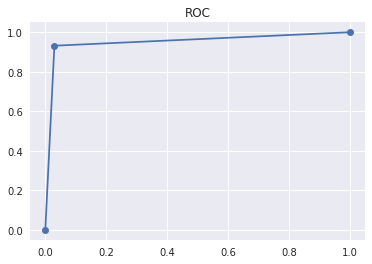

auc 0.9510229342135216
Accuary: 95.71%


In [246]:
accuracy,acc=calculate_kfold(train_label_np,train_preds)

# 4.算法调优

## 4.1 利用交叉验证进行参数寻优
将KNN的超参数K值分别设置为1-10，然后对当前模型做K折交叉验证，分别将KNN的K值为1-10时的ROC曲线、auc值、准确率值打印下来：

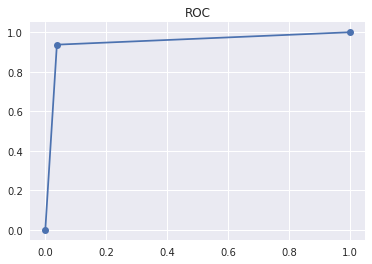

auc 0.9495646483041202
Accuary: 95.35%


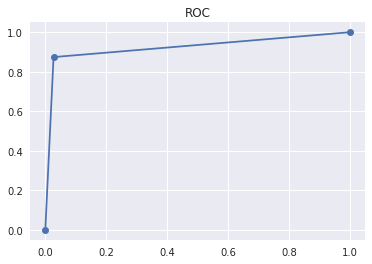

auc 0.9235858183473707
Accuary: 93.92%


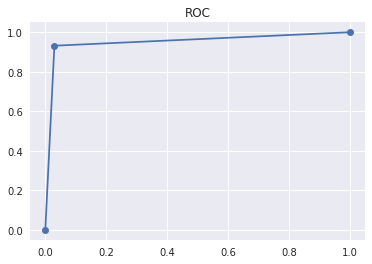

auc 0.9510229342135216
Accuary: 95.71%


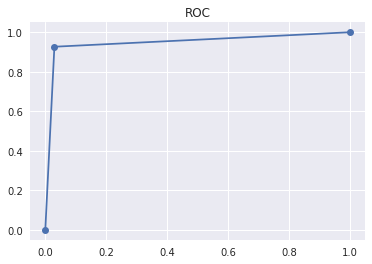

auc 0.9484051331664012
Accuary: 95.53%


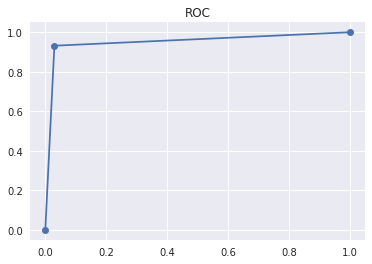

auc 0.9510229342135216
Accuary: 95.71%


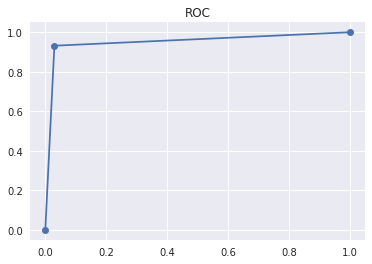

auc 0.9510229342135216
Accuary: 95.71%


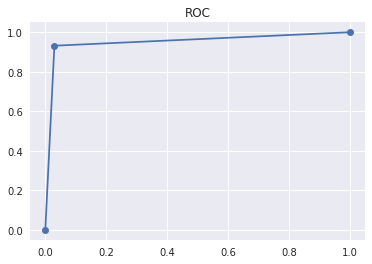

auc 0.9510229342135216
Accuary: 95.71%


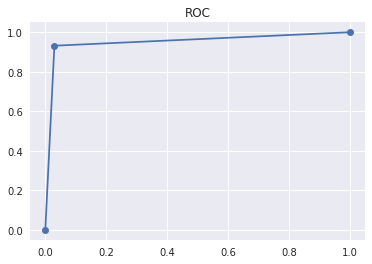

auc 0.9510229342135216
Accuary: 95.71%


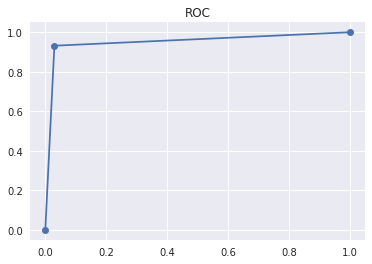

auc 0.9510229342135216
Accuary: 95.71%


In [247]:
accuracy_list=[]
auc_list=[]
k_range=range(1,10)
for i in k_range:
    train_preds=train_kfold(train_data,i,5,is_print_metric_dict=False)
    accuracy,auc=calculate_kfold(train_label_np,train_preds)
    accuracy_list.append(accuracy)
    auc_list.append(auc)


绘制出KNN的超参数K值与交叉验证得到的评估结果auc值和准确率关系的曲线：
如下可以看到当K值取3或大于5的时候，auc和准确率都最高。为了节省计算量，我们将K值取为3、

Text(0,0.5,'auc or accuracy')

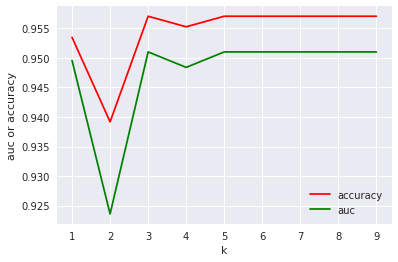

In [249]:
plt.plot(k_range,accuracy_list,color='r',label='accuracy')
plt.plot(k_range,auc_list,color='g',label='auc')
plt.legend(loc="lower right")
plt.xlabel('k')
plt.ylabel('auc or accuracy')


## 4.2 重新训练模型
找到KNN最优K值之后，我们在全部训练集上重新训练模型，得到最终模型，并使用独立测试集对模型性能做出最终评价。

In [250]:
train_data_frame = read_csv(train_data_path)
knn_classification = KNNClassification().set_k(3)
model = knn_classification.fit(train_data_frame)  #训练

test_data_frame = read_csv(test_data_path)
metric_dict = {}
calculate_metric_value(model, test_data_frame)   #测试
print(metric_dict)

{'f1': 0.9643627571057185, 'accuracy': 0.9642857142857143, 'precision': 0.9645453687092815, 'recall': 0.9642857142857143}
